In [2]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

origin_folder = "/home/m12gbs1/working/hongong/ssl-in-medical-image-segmentation/data/livecells"
proceeded_folder = "/home/m12gbs1/working/hongong/ssl-in-medical-image-segmentation/processed_data/livecells"
dim = (512, 512)

# Download data

In [2]:
# Download LIVECell train and test images to data/livecells and unzip
!wget "http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip" -P data/livecells
!unzip -q data/livecells/images.zip -d data/livecells

--2024-09-06 14:48:44--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 3.5.138.118, 52.219.169.62, 3.5.139.64, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|3.5.138.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1241715651 (1,2G) [application/zip]
Saving to: ‘data/livecells/images.zip’

images.zip          100%[===================>]   1,16G  9,60MB/s    in 2m 5s   

2024-09-06 14:50:50 (9,46 MB/s) - ‘data/livecells/images.zip’ saved [1241715651/1241715651]



In [3]:
# get annotations
!wget "http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/4_train50percent.json" -P data/livecells


--2024-09-06 14:50:57--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/4_train50percent.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 3.5.136.167, 3.5.135.40, 3.5.137.173, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|3.5.136.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282314219 (269M) [application/json]
Saving to: ‘data/livecells/4_train50percent.json’

4_train50percent.js 100%[===================>] 269,24M  8,03MB/s    in 37s     

2024-09-06 14:51:34 (7,30 MB/s) - ‘data/livecells/4_train50percent.json’ saved [282314219/282314219]



# Load dataset and calculate max annotations per image


In [3]:

# read original LIVEcell annotation file 
livecell_annotations = os.path.join(origin_folder, "4_train50percent.json")
with open(livecell_annotations) as json_file:
    source = json.load(json_file)


In [10]:
# check max. number of annotations per image for box_detections_per_img hyperparameter 
annotations_per_image = []

for img_idx, image in enumerate(source['images']):
    id = image['id']
    image_annotations = [annotation for annotation in source['annotations'] if annotation['image_id'] == id]
    annotations_per_image.append(len(image_annotations))

print ('Maximum number of annotations per image:', max(annotations_per_image))

Maximum number of annotations per image: 3091


In [14]:
len(image_annotations)

162

In [16]:
image_annotations[0]

{'id': 364559,
 'image_id': 364558,
 'category_id': 1,
 'segmentation': [[6.86,
   47.02,
   5.21,
   46.81,
   4.59,
   46.19,
   3.55,
   45.36,
   2.51,
   44.32,
   0.86,
   42.67,
   0.24,
   41.84,
   0.03,
   40.39,
   0.44,
   30.04,
   1.89,
   27.97,
   3.34,
   26.93,
   5.0,
   25.9,
   7.69,
   24.65,
   8.52,
   24.45,
   9.55,
   24.45,
   9.55,
   24.45,
   10.8,
   25.9,
   12.66,
   28.38,
   14.32,
   29.62,
   16.8,
   30.87,
   18.46,
   31.28,
   19.49,
   32.94,
   19.49,
   35.21,
   19.49,
   37.08,
   18.66,
   38.53,
   18.66,
   40.18,
   18.66,
   42.67,
   19.28,
   44.32,
   20.73,
   46.6,
   21.56,
   48.67,
   21.98,
   51.16,
   22.6,
   52.4,
   21.15,
   52.4,
   18.66,
   50.95,
   16.8,
   49.5,
   14.52,
   48.46,
   12.04,
   47.84,
   9.55,
   47.43,
   8.52,
   46.81]],
 'area': 383.69585000000006,
 'bbox': [0.03, 24.45, 22.57, 27.95],
 'iscrowd': 0}

In [17]:
image_annotations[0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

# Load training images

In [18]:
import os
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from pycocotools.coco import COCO

class CocoDataset(Dataset):
    def __init__(self, root, ann_file, transforms=None):
        """
        Args:
            root (str): Root directory where images are stored.
            ann_file (str): Path to the COCO annotations file.
            transforms (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        self.coco = COCO(ann_file)
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Get image ID
        img_id = self.ids[idx]
        # Load image
        img_data = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_data['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get annotations (masks)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Create a mask with the same size as the image
        mask = np.zeros((img_data['height'], img_data['width']), dtype=np.uint8)

        for ann in anns:
            # Create binary mask for each annotation
            mask_per_instance = self.coco.annToMask(ann)
            # Merge masks (assumes single class for now)
            mask = np.maximum(mask, mask_per_instance * ann['category_id'])

        sample = {'image': image, 'mask': mask}

        # Apply transforms
        if self.transforms:
            sample = self.transforms(sample)

        return sample


In [23]:
class CocoDataset(Dataset):
    def __init__(self, root, ann_file, transforms=None):
        self.root = root
        self.coco = COCO(ann_file)
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_data = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_data['file_name'])
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations (masks)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Create an empty mask with the same size as the image
        mask = np.zeros((img_data['height'], img_data['width']), dtype=np.uint8)

        for ann in anns:
            # Create binary mask for each annotation
            mask_per_instance = self.coco.annToMask(ann)

            # Resize mask_per_instance to the image's dimensions if they don't match
            if mask_per_instance.shape != image.shape[:2]:
                mask_per_instance = cv2.resize(mask_per_instance, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Merge masks (single class for now)
            mask = np.maximum(mask, mask_per_instance * ann['category_id'])

        sample = {'image': image, 'mask': mask}

        if self.transforms:
            sample = self.transforms(sample)

        return sample


loading annotations into memory...
Done (t=3.23s)
creating index...
index created!


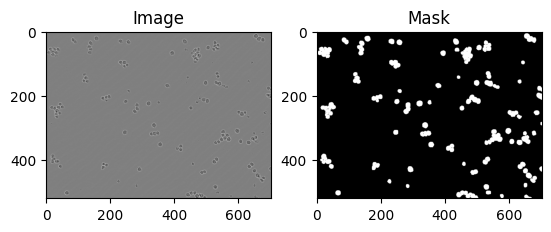

In [24]:
root_dir = os.path.join(origin_folder, "images", "livecell_train_val_images")
ann_file = os.path.join(origin_folder, "4_train50percent.json")

dataset = CocoDataset(root=root_dir, ann_file=ann_file)

# Example usage
sample = dataset[0]
image, mask = sample['image'], sample['mask']

# Display image and mask
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.show()


In [ ]:
import os
import cv2
from tqdm import tqdm

# Paths for saving images and masks
output_image_dir = os.path.join(origin_folder, "output_images")
output_mask_dir = os.path.join(origin_folder, "output_masks")

# Create directories if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Iterate through the dataset and save images/masks
for i in tqdm(range(len(dataset))):
    sample = dataset[i]
    image, mask = sample['image'], sample['mask']

    # Convert image from RGB to BGR for saving with OpenCV
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Get the file name from the dataset
    img_id = dataset.ids[i]
    img_data = dataset.coco.loadImgs(img_id)[0]
    file_name = img_data['file_name'].split('.')[0]  # Get file name without extension

    # Check if image and mask shapes match
    if image.shape[:2] != mask.shape:
        print(f"Shape mismatch for {file_name}: resizing mask")
        # Resize the mask to match the image size
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Define output paths
    image_output_path = os.path.join(output_image_dir, f'{file_name}.jpg')
    mask_output_path = os.path.join(output_mask_dir, f'{file_name}.png')

    # Save the image
    cv2.imwrite(image_output_path, image_bgr)

    # Save the mask
    cv2.imwrite(mask_output_path, mask)

    print(f"Saved image and mask for {file_name}")

# Convert to numpy

In [29]:
image_dir_path = origin_folder + "/output_images/"
mask_dir_path = origin_folder + "/output_masks/"

image_path_list = os.listdir(image_dir_path)
mask_path_list = os.listdir(mask_dir_path)

# align masks and inputs
image_path_list.sort()
mask_path_list.sort()

print(
    "number of images: {}, number of masks: {}".format(
        len(image_path_list), len(mask_path_list)
    )
)

number of images: 1624, number of masks: 1624


In [30]:
# store numpy standard dataset
for image_path, mask_path in tqdm(zip(image_path_list, mask_path_list)):
    # assert image_path == mask_path
    assert os.path.basename(image_path)[:-4] == os.path.basename(mask_path)[:-4]

    # load image and mask
    _id = os.path.basename(image_path)[:-4]
    image_path = os.path.join(image_dir_path, image_path)
    mask_path = os.path.join(mask_dir_path, mask_path)
    image = plt.imread(image_path)

    #
    mask = plt.imread(mask_path)
    if len(mask.shape) == 3:
        mask = np.int64(np.all(mask[:, :, :3] == 1, axis=2))

    # resize image and mask to 512x512 pixels
    image_new = cv2.resize(image, dim, interpolation=cv2.INTER_CUBIC)
    mask_new = cv2.resize(mask, dim, interpolation=cv2.INTER_NEAREST)

    # save image and mask
    save_dir_path = proceeded_folder + "/images"
    os.makedirs(save_dir_path, exist_ok=True)
    np.save(os.path.join(save_dir_path, _id + ".npy"), image_new)

    save_dir_path = proceeded_folder + "/labels"
    os.makedirs(save_dir_path, exist_ok=True)
    np.save(os.path.join(save_dir_path, _id + ".npy"), mask_new)

1624it [00:08, 199.37it/s]


In [31]:
# store numpy standard dataset
ls_image_id = []
for image_path, mask_path in tqdm(zip(image_path_list, mask_path_list)):
    # assert image_path == mask_path
    assert os.path.basename(image_path)[:-4] == os.path.basename(mask_path)[:-4]

    # load image and mask
    _id = os.path.basename(image_path)[:-4]
    ls_image_id.append(_id)

print(len(ls_image_id))

1624it [00:00, 1092119.56it/s]

1624


In [32]:
# split ls_image_id into 5 folds
np.random.seed(0)
np.random.shuffle(ls_image_id)
fold_size = len(ls_image_id) // 5
ls_folds = []
for i in range(5):
    ls_folds.append(ls_image_id[i * fold_size : (i + 1) * fold_size])

# save folds as txt
save_dir_path = proceeded_folder
os.makedirs(save_dir_path, exist_ok=True)
for i, fold in enumerate(ls_folds):
    with open(os.path.join(save_dir_path, "fold{}.txt".format(i + 1)), "w") as f:
        for item in fold:
            file_name = f"{item}.npy"
            f.write("%s\n" % file_name)